## Figure 2

This manuscript generates figure 2 and relavent data of the paper. 

Kexin Dong

Date created: May 24, 2024  

Last updated: Oct 20, 2025


In [82]:
import matplotlib as mpl
import scipy.stats
mpl.rcParams['pdf.fonttype'] = 42   
mpl.rcParams['ps.fonttype'] = 42 
mpl.rcParams['text.usetex'] = False 
import bioh2m as h2m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.colors as mcolors
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from sksurv.nonparametric import kaplan_meier_estimator
from statannotations.Annotator import Annotator
from matplotlib.ticker import FixedLocator, FuncFormatter
import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Figure 2d 

Scatter plot of frequencies of KIT missense mutations in cancer patients according to AACR-GENIE, colored by H2M modeling. 

In [45]:
df_input = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/aacr_input_original.csv')
df_input_sub = df_input[(df_input['gene_name_h']=='KIT')]

In [46]:
df_binded = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/database-output-final/df_result_cleaned_v3.csv')

In [47]:
df_kit_all = df_binded[(df_binded['gene_name_h']=='KIT') & (df_binded['classification_h']=='Missense')]

In [48]:
df_kit_all = df_kit_all.reset_index(drop=True)
df_kit_aacr = df_kit_all[df_kit_all['Database']=='AACR']
df_kit_aacr = df_kit_aacr[df_kit_aacr['ID_human'].isin(df_input_sub['ID'])]
df_kit_aacr = df_kit_aacr.reset_index(drop=True)
# del bf_binded

In [49]:
df_input_sub = df_input_sub.rename(columns = {'ID':'ID_human'})
df_freq = pd.merge(df_input_sub, df_kit_aacr, on=['gene_name_h', 'tx_id_h', 'start_h', 'end_h', 'ref_seq_h', 'alt_seq_h',
       'type_h','ID_human'], how = 'left')
df_freq_all = pd.merge(df_input_sub, df_kit_all, on='ID_human', how = 'right')

In [50]:
len(df_freq_all)

4159

In [51]:
len(df_freq)

2943

In [52]:
color_dict_h2m = dict({0:'tab:orange',
                  1:'tab:green',
                  4:'tab:purple'})

def search_loc(s):
    match = re.search(r'(\d+)', s)
    if match:
        number = match.group(1)
        return int(number)
    else:
        return None

In [53]:
df_merged_all = df_freq
df_merged_all = df_merged_all[df_merged_all['classification_h'] == 'Missense'].reset_index(drop=True)
df_merged_all['loc_h'] = [search_loc(s) for s in  df_merged_all['HGVSp_h']]
# df_merged_all['color'] = [color_dict[x] for x in df_merged_all['am_class']]
df_merged_all['color_h2m'] = [color_dict_h2m[x] for x in df_merged_all['class']]

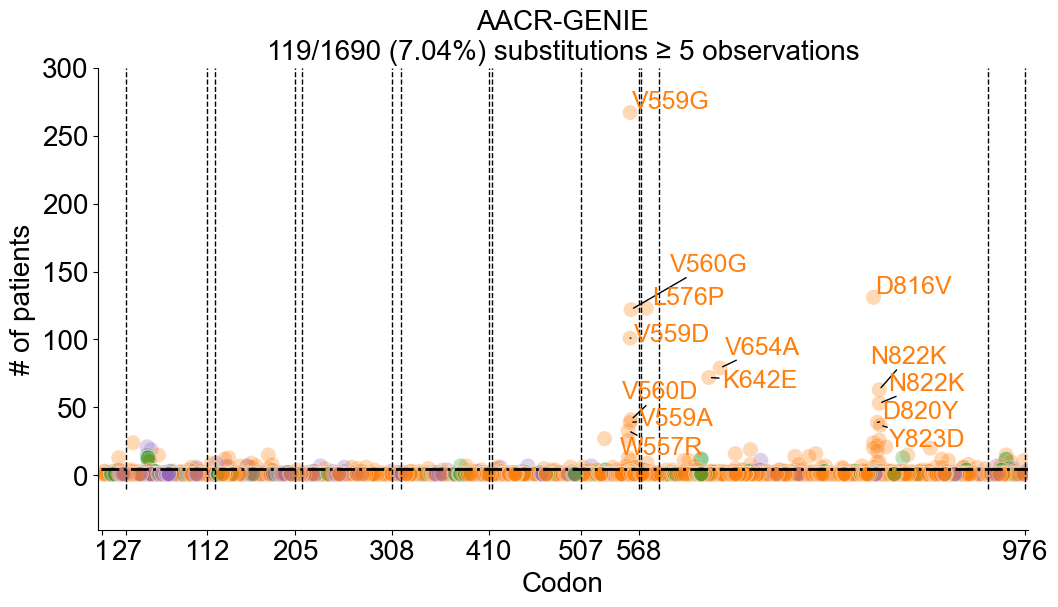

In [ ]:
fs = 0
df_merged = df_merged_all[df_merged_all['flank_size'] >= fs].reset_index(drop=True)
gene = 'KIT'
l1 = len(df_merged_all['HGVSp_h'].drop_duplicates())
l2 = len(df_merged_all[df_merged_all['count']>=5]['HGVSp_h'].drop_duplicates())
percent = 100*l2/l1
bbb1 = df_merged[(df_merged['count'] >= 30) ]

bb2 = bbb1

t = list(bb2['HGVSp_h'])
x = list(bb2['loc_h'])
y = list(bb2['count'])
c= list(bb2['color_h2m'])

fig, ax = plt.subplots(figsize=(12, 6))

g = ax.scatter(data=df_merged, x='loc_h', y='count',  c = 'color_h2m', alpha=.3, s=120, edgecolor='white', linewidths=.5)


ax.plot([0, 979], [5, 5], linewidth=2, linestyle='-.', color='black')
# ax.set_ylim(-6, 6)
ax.set_xlim(-3, 979)
ax.set_ylim(-40, 300)
ax.set_ylabel(f"# of patients", fontsize=20)
ax.set_xlabel("Codon", fontsize=20)
ax.set_title(f"AACR-GENIE\n{l2}/{l1} ({percent:.2f}%) substitutions ≥ 5 observations", fontsize=20)
boundaries = [27,112,121,205,212,308,317,410,413,507,568,570,589,937,976]
boundaries_ = [1,27,112,205,308,410,507,568,976]
for bound in boundaries:
    ax.plot([bound, bound], [-10, 300], linewidth=1, linestyle='dashed', color='black')

texts = [
    ax.text(
        x[i], y[i], t[i],
        fontsize=18, color=c[i],
    )
    for i in range(len(x))
]

adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', which='major', labelsize=20)

ax.xaxis.set_ticks(boundaries_)
ax.xaxis.set_ticklabels(boundaries_, size=20, fontweight=100)

plt.savefig(f'figures/2d.pdf', bbox_inches='tight')
plt.show()

# Figure 2e

Kaplan-Meier Curve visualizing the percentage of human KIT missense mutations that can be modeled by H2M, stratified by functional domain. 

In [37]:
df_merged_all = df_kit_all
df_merged_all = df_merged_all[df_merged_all['classification_h'] == 'Missense'].reset_index(drop=True)
df_merged_all['loc_h'] = [search_loc(s) for s in  df_merged_all['HGVSp_h']]
# df_merged_all['color'] = [color_dict[x] for x in df_merged_all['am_class']]
df_merged_all['color_h2m'] = [color_dict_h2m[x] for x in df_merged_all['class']]

In [38]:
t = ['IG','Trans-/Juxta-membrane','Kinase']
def get_class_region(x):
    t = ['IG','Trans-/Juxta-membrane','Kinase']
    if x <= 507:
        return t[0]
    elif x<= 589:
        return t[1]
    else:
        return t[2]
df_merged_all['region'] = [get_class_region(x) for x in df_merged_all['loc_h']]
color_dict_region = dict(zip(t, ['tab:green','tab:orange','tab:purple']))
df_merged_all['color_region'] = [color_dict_region[x] for x in df_merged_all['region']]

In [39]:
df_merged_all = df_merged_all.drop_duplicates(subset='ID_human').reset_index(drop=True)

In [40]:
df_merged_all['status'] = True

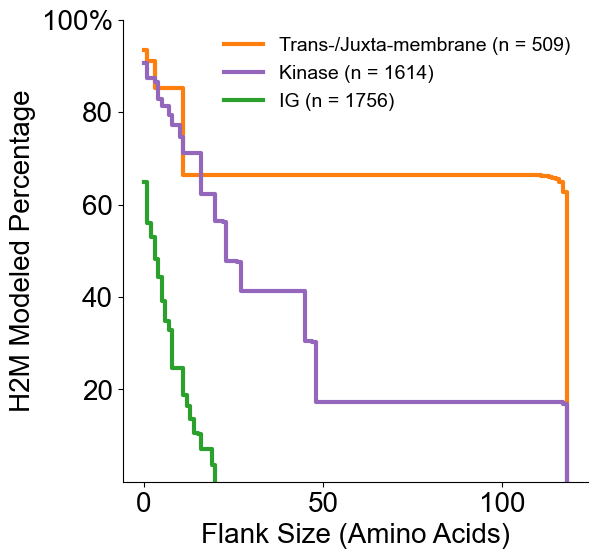

In [41]:
fig, ax = plt.subplots(figsize=(6, 6), ncols=1, nrows=1)
for value in df_merged_all['region'].unique():
    mask = df_merged_all['region'] == value
    color = color_dict_region[value]
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df_merged_all["status"][mask], df_merged_all["flank_size"][mask], conf_type="log-log",
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})", 
             color = color, linewidth=3)
    # plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.yaxis.set_ticks([0.20,0.40,0.60,0.80,1])
ax.yaxis.set_ticklabels(['20','40','60','80','100%'], size=20, fontweight=100)
ax.set_ylabel(f"H2M Modeled Percentage", fontsize=20)
ax.set_xlabel("Flank Size (amino acids)", fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

plt.ylim(0, 1)
plt.xlabel("Flank Size (Amino Acids)")
plt.legend(loc="best",fontsize=14, frameon=False)
plt.savefig(f'figures/2e.pdf', bbox_inches='tight')
plt.show()

# Figure 2f

Relationship between SIFT pathogenicity scores for human-mouse mutation pairs in KIT, log-scaled. Mutation pairs are selected according to the occurrence of human mutations in AACR-GENIE ≥ 5 patients.

In [18]:
sift_m = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/SIFT_input/sift_m_2.txt',sep='\t', comment = '#')
sift_h = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/SIFT_input/sift_h_2.txt',sep='\t', comment = '#')

In [61]:
sift_m_result = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/SIFT_output/sift_m_2_SIFT_kit.csv')
sift_m.columns = ['CHROM',	'start_m',	'ID_human',	'ref_seq_m',	'alt_seq_m',	'QUAL',	'FILTER',	'INFO',	'FORMAT',	'MP96-Ripoll-MRC-Harwell']
sift_h.columns = ['CHROM',	'start_h',	'ID_human',	'ref_seq_h',	'alt_seq_h',	'QUAL',	'FILTER',	'INFO',	'FORMAT',	'MP96-Ripoll-MRC-Harwell']
# df_binded = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/database-output-final/df_result_cleaned_v3.csv')
sub_result_m = sift_m_result[['POS','REF_ALLELE','ALT_ALLELE','SIFT_SCORE','SIFT_PREDICTION']]
sub_result_m.columns = ['start_m','ref_seq_m','alt_seq_m','SIFT_SCORE','SIFT_PREDICTION']
sub_result_m = pd.merge(sift_m,sub_result_m, how='outer',on = ['start_m','ref_seq_m','alt_seq_m'])

In [62]:
sift_h_result = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/h2m_database/SIFT/sift_h_SIFT_kit.csv')
sub_result_h = sift_h_result[['POS','REF_ALLELE','ALT_ALLELE','SIFT_SCORE','SIFT_PREDICTION']]
sub_result_h.columns = ['start_h','ref_seq_h','alt_seq_h','SIFT_SCORE','SIFT_PREDICTION']
sift_h_result = pd.merge(sift_h,sub_result_h, how='outer',on = ['start_h','ref_seq_h','alt_seq_h'])

sift_h_result_plot = sift_h_result[['ID_human','SIFT_SCORE','SIFT_PREDICTION']]
sift_h_result_plot.columns = ['ID_human','SIFT_SCORE_h','SIFT_PREDICTION_h']
sift_m_result_plot = sub_result_m[['ID_human','SIFT_SCORE','SIFT_PREDICTION']]
sift_m_result_plot.columns = ['ID_human','SIFT_SCORE_m','SIFT_PREDICTION_m']

In [63]:
df_SIFT_kit = pd.merge(sift_h_result_plot, sift_m_result_plot, on = 'ID_human').dropna()

In [64]:
df_SIFT_kit

,ID_human,SIFT_SCORE_h,SIFT_PREDICTION_h,SIFT_SCORE_m,SIFT_PREDICTION_m
1,AACR-H0004152,0.416,TOLERATED,0.681,TOLERATED
3,AACR-H0010103,0.797,TOLERATED,0.105,TOLERATED
8,AACR-H0012038,0.267,TOLERATED,0.296,TOLERATED
9,AACR-H0007687,0.248,TOLERATED,0.262,TOLERATED
10,AACR-H0030639,0.135,TOLERATED,0.128,TOLERATED
...,...,...,...,...,...
115,AACR-H0048772,0.166,TOLERATED,0.308,TOLERATED
116,AACR-H0026674,0.097,TOLERATED,0.107,TOLERATED
117,AACR-H0007529,0.009,DELETERIOUS,0.046,DELETERIOUS
122,AACR-H0014362,0.281,TOLERATED,0.122,TOLERATED


In [65]:
df_SIFT_kit = pd.merge(df_SIFT_kit, df_freq[['ID_human','HGVSp_h','HGVSp_m','class']], on = 'ID_human').drop_duplicates()
df_SIFT_kit = pd.merge(df_SIFT_kit, df_freq[['ID_human','flank_size']], on = 'ID_human').drop_duplicates()
df_SIFT_kit = pd.merge(df_SIFT_kit, df_freq[['ID_human','classification_h']], on = 'ID_human').drop_duplicates()
df_SIFT_kit = df_SIFT_kit[df_SIFT_kit['classification_h']!='Silent']

In [66]:
df_SIFT_kit['SIFT_PREDICTION_h'].value_counts()

SIFT_PREDICTION_h
DELETERIOUS    55
TOLERATED      41
Name: count, dtype: int64

In [67]:
color_dict_sift = ({
    'DELETERIOUS':'darkred',
    'TOLERATED':'tab:blue'
})
df_h2m = df_SIFT_kit

In [68]:
# Function to blend two colors
def blend_colors(color1, color2):
    # Convert color names to RGBA
    rgb1 = np.array(mcolors.to_rgb(color1))
    rgb2 = np.array(mcolors.to_rgb(color2))
    # Calculate the average of the RGB components
    blended_rgb = (rgb1 + rgb2) / 2
    # Convert the blended RGB back to hex color code
    return mcolors.to_hex(blended_rgb)

# Create a combined color dictionary
combined_color_dict = {}
for key1 in color_dict_sift:
    for key2 in color_dict_sift:
        # Blend each pair of colors
        combined_color_dict[(key1, key2)] = blend_colors(color_dict_sift[key1], color_dict_sift[key2])

In [69]:
df_h2m['color_class'] = [color_dict_h2m[x] for x in df_h2m['class']]
df_h2m['color_score'] = df_h2m.apply(lambda row: combined_color_dict[(row['SIFT_PREDICTION_h'], row['SIFT_PREDICTION_m'])], axis=1)
df_h2m['loc_h'] = [search_loc(s) for s in  df_h2m['HGVSp_h']]
df_h2m['loc_m'] = [search_loc(s) for s in  df_h2m['HGVSp_m']]
df_h2m['color_h2m_h'] = [color_dict_sift[x] for x in df_h2m['SIFT_PREDICTION_h']]
df_h2m['color_h2m_m'] = [color_dict_sift[x] for x in df_h2m['SIFT_PREDICTION_m']]

In [70]:
corr, p_value = scipy.stats.spearmanr(df_h2m['SIFT_SCORE_h'], df_h2m['SIFT_SCORE_m'])

print("Spearman Correlation Coefficient: {:.4f}".format(corr))
print(p_value)

Spearman Correlation Coefficient: 0.9678
4.347276326415532e-58


In [71]:
corr_p, p_value = scipy.stats.pearsonr(df_h2m['SIFT_SCORE_h'], df_h2m['SIFT_SCORE_m'])

print("Pearson Correlation Coefficient: {:.4f}".format(corr_p))
print(p_value)

Pearson Correlation Coefficient: 0.9114
5.204596131735645e-38


In [72]:
n_of_subs = len(df_h2m['HGVSp_h'].unique())

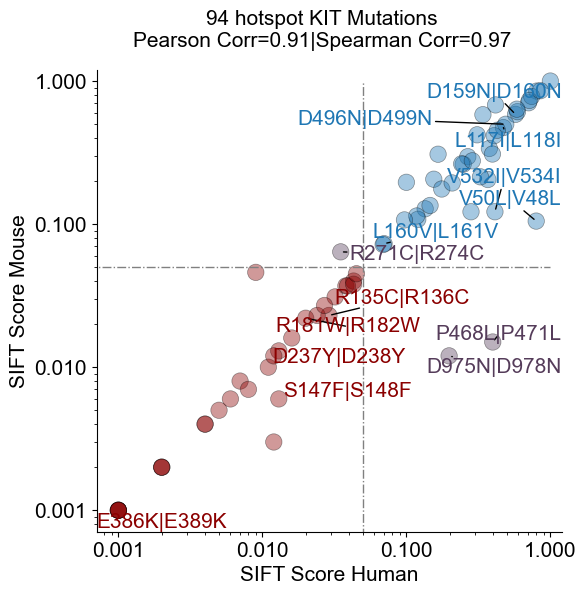

In [73]:
fig, ax = plt.subplots(figsize=(6, 6))
gene_1 = 'KIT'
gene_2 = 'Kit'

bbb1 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m']<=.05)].iloc[:5,:]
bbb2 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= .4) & (df_h2m['SIFT_SCORE_m'] <= .6)].iloc[:5,:]
bbb3 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= .097) & (df_h2m['SIFT_SCORE_m'] <= .097) ].iloc[:3,:]
bbb4 = df_h2m[(df_h2m['SIFT_SCORE_h'] <= 0.05) & (df_h2m['SIFT_SCORE_m'] >= .05) ].iloc[:3,:]
bbb5 = df_h2m[(df_h2m['SIFT_SCORE_h'] >= 0.05) & (df_h2m['SIFT_SCORE_m'] <= 0.05) ].iloc[:3,:]
bbb6 = df_h2m[df_h2m['class']==1]


bb2 = pd.concat((bbb1, bbb2,bbb3, bbb4,bbb5, bbb6)).drop_duplicates(subset= 'HGVSp_h')

t = [f'{x}|{y}' for x,y in zip(bb2['HGVSp_h'], bb2['HGVSp_m'])]
x = list(bb2['SIFT_SCORE_h'])
y = list(bb2['SIFT_SCORE_m'])
c = list(bb2['color_score'])


ax.plot([0, 1], [0.05, 0.05], linewidth=1, linestyle='-.', color='grey')
ax.plot( [0.05, 0.05], [0, 1],linewidth=1, linestyle='-.', color='grey')

plt.xscale('log')
plt.yscale('log')
# ax.plot( [0,1], [0, 1],linewidth=1, linestyle='-', color='grey')
ax.scatter(data=df_h2m, x='SIFT_SCORE_h', y='SIFT_SCORE_m', c = 'color_score', alpha=.4, s=140, edgecolor='black', linewidths=.5)

ax.set_xlim(-.03, 1.2)
ax.set_ylim(-.03, 1.2)
ax.set_xlabel(f"SIFT Score Human", fontsize=15)
ax.set_ylabel(f"SIFT Score Mouse", fontsize=15)
plt.suptitle(f"{n_of_subs} hotspot KIT Mutations\nPearson Corr={corr_p:.2f}|Spearman Corr={corr:.2f}", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
texts = [ax.text(x[i], y[i], t[i], 
                 fontsize=15, 
                 color=c[i])
                 for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
def format_func(value, tick_number):
    return f"{value:.3f}"
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.savefig(f'figures/2f.pdf', bbox_inches='tight')
plt.show()

# Figure 2g

Schematic of the generation of human-mouse immunogenic peptide pairs from mutation-derived, experiment-validated human tumor neoantigens, and the relationship of MHC-I binding percentile rank (%Rank) between them. 

In [74]:
def dict_score_class(h,m):
    if h <= 2 and m <=2:
        if h <= .5 and m<= .5:
            return 'strong'
        else:
            return 'both'
    elif m>2:
        if h<=2:
            return 'honly'
        else:
            return 'neither'
    else:
        return 'monly'
    
dict_color_class = {
    'strong':'darkred',
    'both':'tab:purple',
    'honly':'tab:orange',
    'monly':'tab:blue',
    'neither':'grey'
}

In [75]:
l_final = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/neoantigen/final_result/h2m_neoantigen_result_v3.csv')

In [76]:
l_final = l_final.sort_values(by='percentile_rank_m').reset_index(drop=True)

In [77]:
l_final['class'] = [dict_score_class(h,m) for h,m in zip(l_final['percentile_rank_h'], l_final['percentile_rank_m'])]
l_final['color'] = [dict_color_class[x] for x in l_final['class']]

In [78]:
correlation, p_value = scipy.stats.spearmanr(list(l_final['percentile_rank_m']), list(l_final['percentile_rank_h']))
print("Spearman correlation coefficient:", correlation)
print("P-value of the correlation:", p_value)

Spearman correlation coefficient: 0.43342075556762044
P-value of the correlation: 5.686625690718467e-19


In [79]:
corr_p, p_value_p = scipy.stats.pearsonr(list(l_final['percentile_rank_m']), list(l_final['percentile_rank_h']))
print("Pearson correlation coefficient:", corr_p)
print("P-value of the correlation:", p_value_p)

Pearson correlation coefficient: 0.11804128445732177
P-value of the correlation: 0.020852399239097447


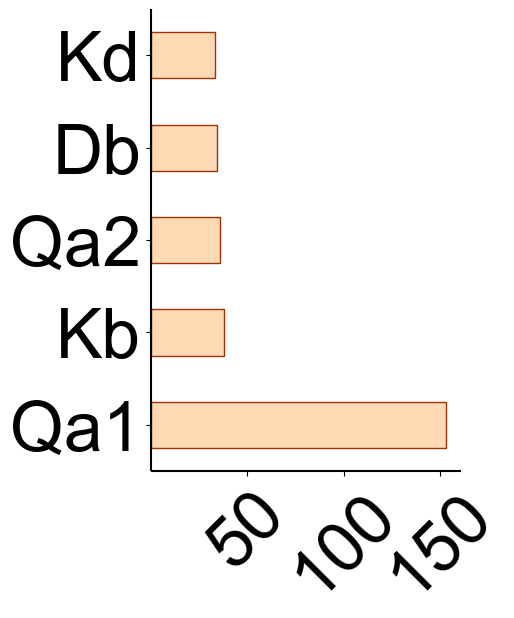

In [84]:
fig, ax = plt.subplots(figsize=(4,6))
allele_counts = l_final['H2_allele'].value_counts()[:5]
allele_counts = allele_counts
allele_counts.plot(kind='barh', color = plt.cm.Oranges(0.2) , edgecolor = plt.cm.Oranges(0.9))
plt.title('H2 Allele Frequency')  
plt.xlabel('Allele') 
plt.ylabel('Frequency') 
plt.xticks(rotation=45)  
ax.set_axisbelow(True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_lw(1.5)
ax.spines["bottom"].set_capstyle("butt")
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks([50,100,150])
ax.xaxis.set_ticklabels([50,100,150], size=50, fontweight=100)
plt.yticks(fontsize = 50)
plt.title('')
plt.savefig('figures/2g_xcount.pdf',bbox_inches='tight')
plt.show()

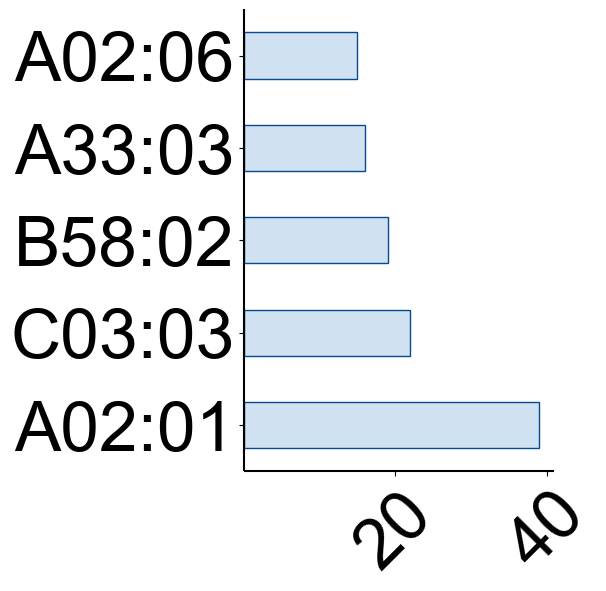

In [85]:
fig, ax = plt.subplots(figsize=(4,6))
allele_counts = l_final['HLA_allele'].value_counts()[:5]
allele_counts = allele_counts
allele_counts.plot(kind='barh', color = plt.cm.Blues(0.2) , edgecolor = plt.cm.Blues(0.9))
plt.title('H2 Allele Frequency')  # 图表标题
plt.xlabel('Allele')  # x轴标签
plt.ylabel('Frequency')  # y轉标签
plt.xticks(rotation=45)  # x轴标签旋转45度
ax.set_axisbelow(True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_lw(1.5)
ax.spines["bottom"].set_capstyle("butt")
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks([20,40])
ax.xaxis.set_ticklabels([20,40], size=50, fontweight=100)
plt.yticks(fontsize = 50)
plt.title('')
plt.savefig('figures/2g_ycount.pdf',bbox_inches='tight')
plt.show()

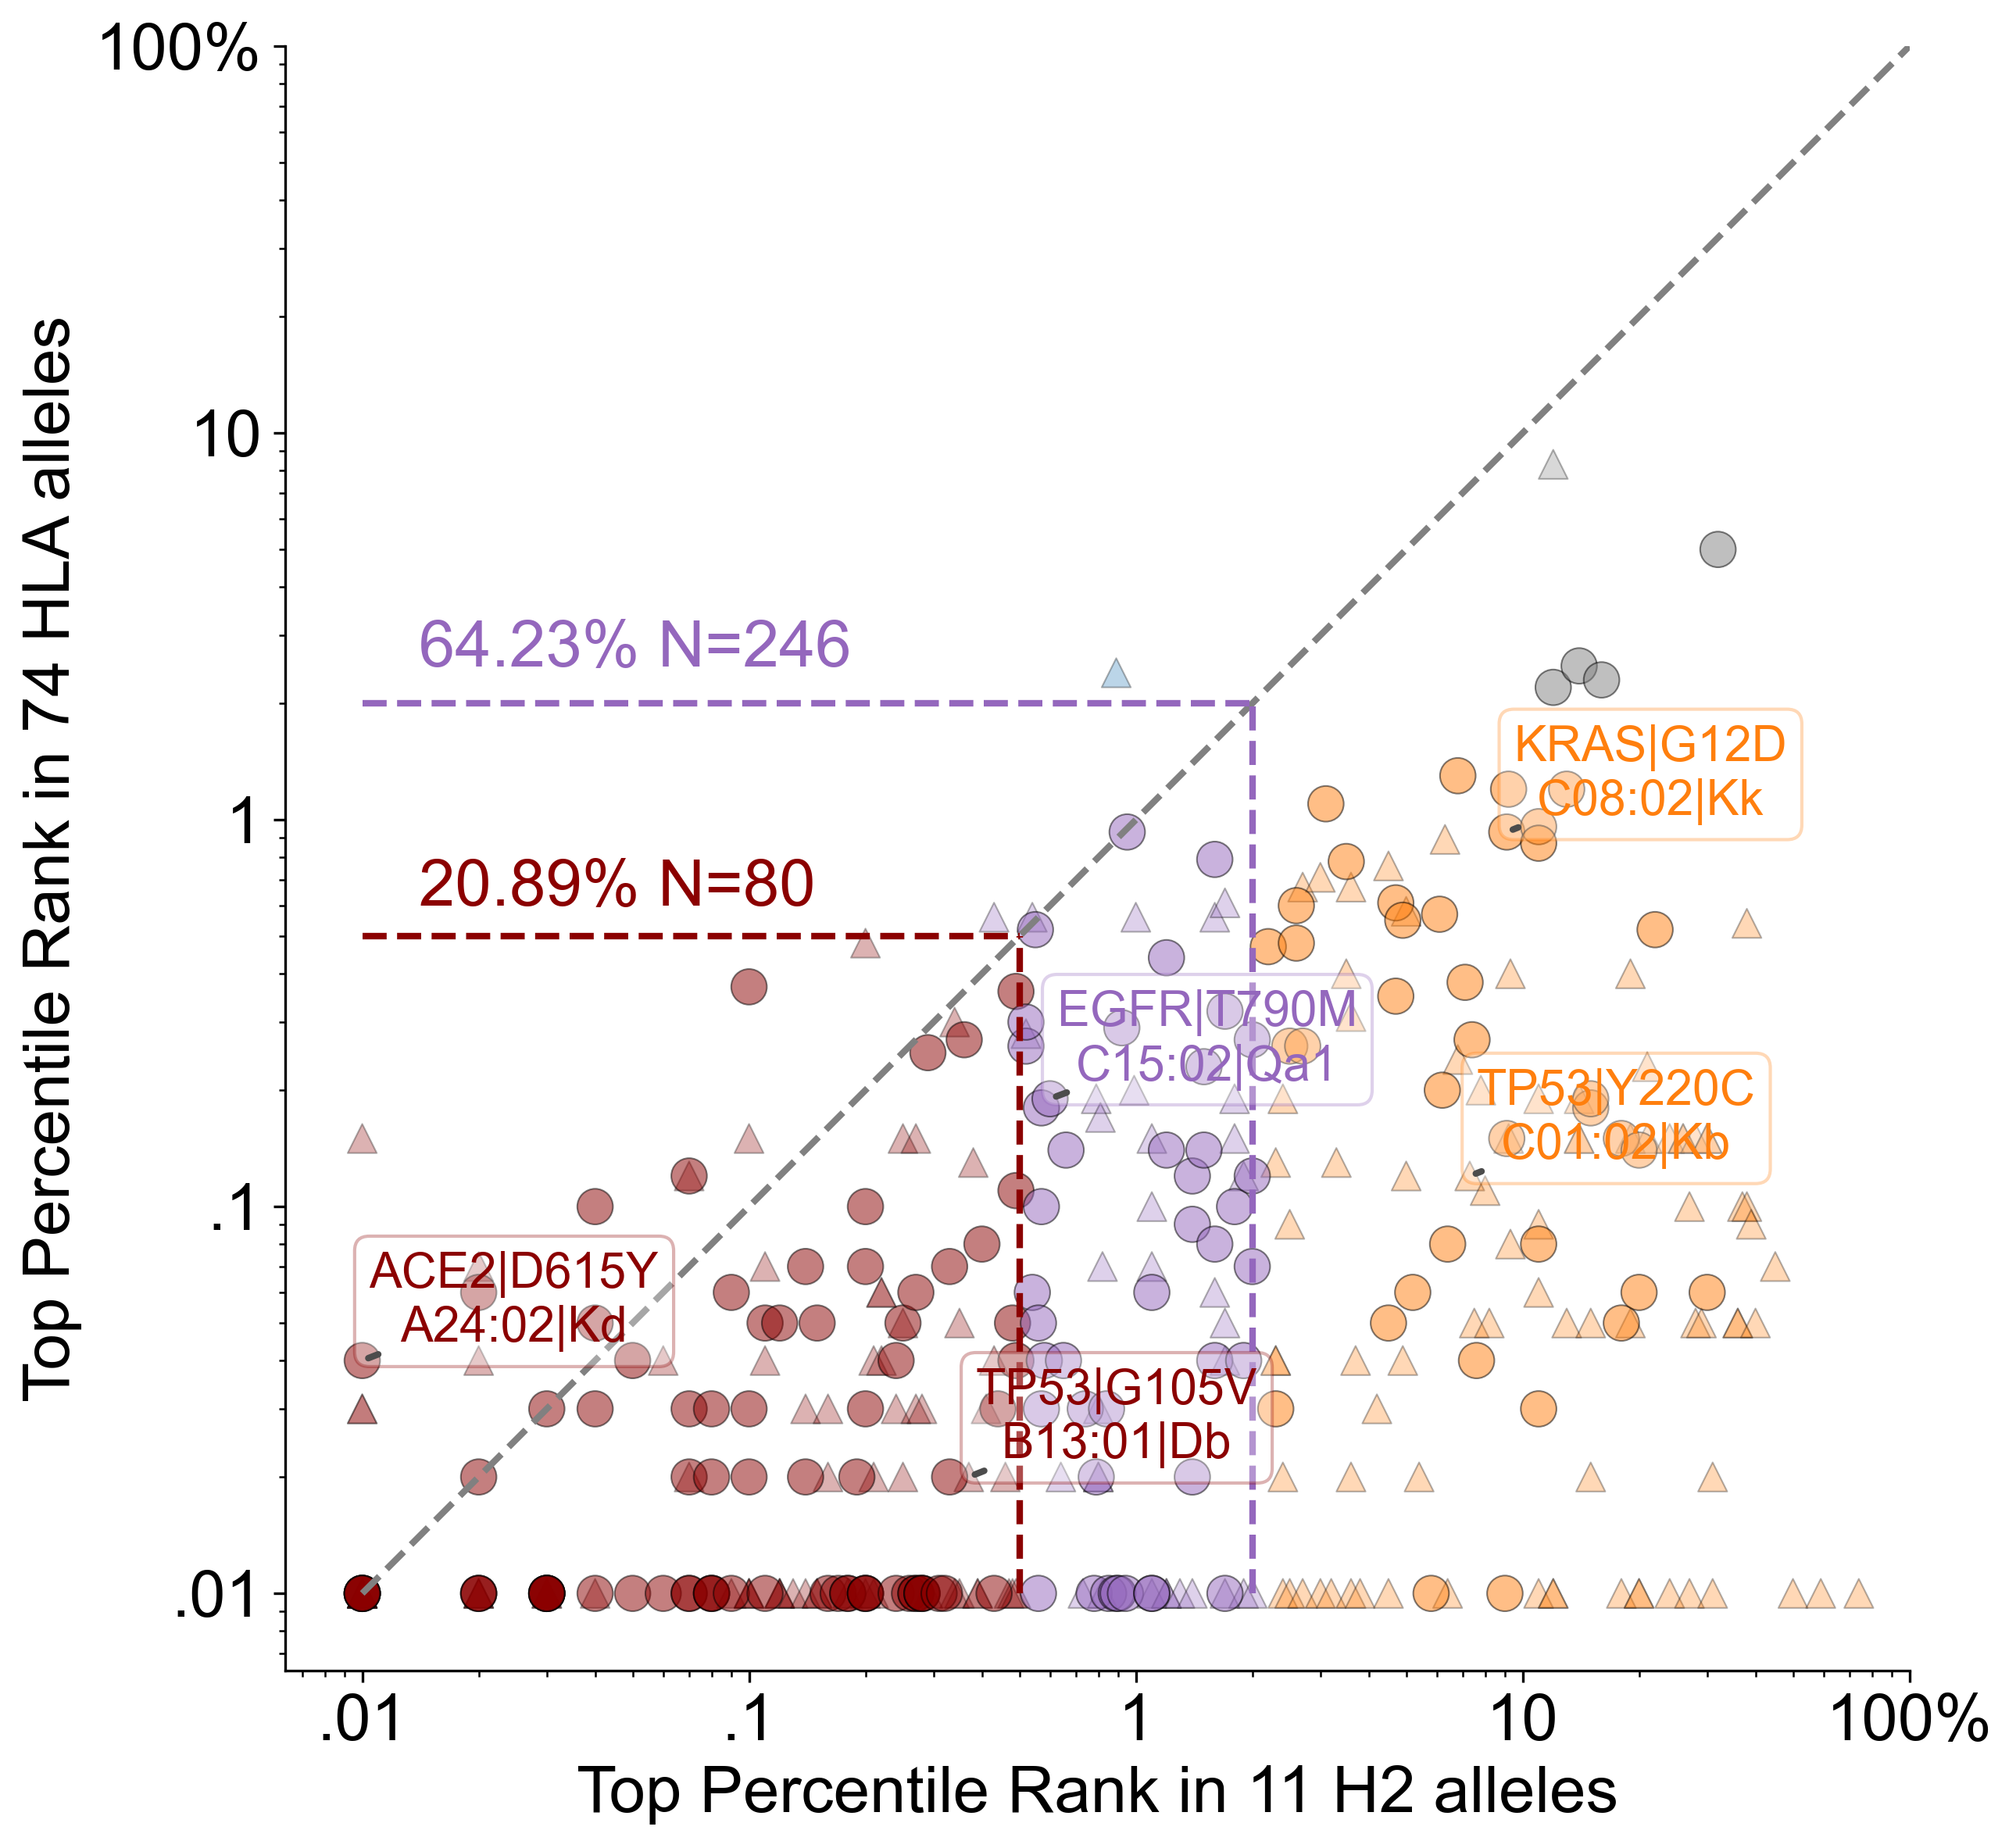

In [83]:
l_plot = l_final
# bbb1 = l_plot[[abs(x-y)<=0.05 for x,y in zip(l_plot['percentile_rank_m'],l_plot['percentile_rank_h'])]].iloc[:3,:]
# bbb2 = l_plot[(l_plot['percentile_rank_h'] <= .01) & (l_plot['percentile_rank_m'] >= 85)].iloc[:3,:]
# top_2 = df_merged['HGVSp_h'].value_counts().index.to_list()[:2]
# bbb3 = df_merged[df_merged['HGVSp_h'].isin(top_2)]
bbb1 = l_plot[l_plot['gene_name_h'].isin(['TP53','KRAS','ACE2','EGFR']) & l_plot['HGVSp_h'].isin(['D615Y','G105V','T790M','G12D','Y220C'])]
bb2 = bbb1.sort_values('percentile_rank_m').drop_duplicates(subset = 'HGVSp_h')

x = list(bb2['percentile_rank_m'])
y = list(bb2['percentile_rank_h'])
t = [f'{x}|{y}\n{p}|{q}' for x,y,p,q in zip(bb2['gene_name_h'], bb2['HGVSp_h'], bb2['HLA_allele'], bb2['H2_allele'])]
c = list(bb2['color'])


fig, ax = plt.subplots(figsize=(9, 9), dpi=300)

plot_1 = l_plot[[x==y for x,y in zip(l_plot['human_9mers'],l_plot['mouse_9mers'])]]
plot_2 = l_plot[[x!=y for x,y in zip(l_plot['human_9mers'],l_plot['mouse_9mers'])]]

ax.scatter(data=plot_2.sort_values('percentile_rank_m').drop_duplicates(subset='mouse_9mers'), x='percentile_rank_m', y='percentile_rank_h', c = 'color',alpha=.3, s=80, edgecolor='black', linewidths=.5, marker='^')
ax.scatter(data=plot_1.sort_values('percentile_rank_m').drop_duplicates(subset='mouse_9mers'), x='percentile_rank_m', y='percentile_rank_h', c = 'color',alpha=.5, s=120, edgecolor='black', linewidths=.5)

plt.xscale('log')
plt.yscale('log')
ax.plot([.01, 100], [.01, 100], linewidth=2, linestyle='--', color='grey')
ax.plot([.01, .5], [.5, .5], linewidth=2, linestyle='--', color='darkred')
ax.plot( [.5, .5], [.01, .5],linewidth=2, linestyle='--', color='darkred')
ax.plot([.01, 2], [2, 2], linewidth=2, linestyle='--', color='tab:purple')
ax.plot([2, 2], [.01, 2],linewidth=2, linestyle='--', color='tab:purple')

ax.set_aspect('equal')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel(f"Top Percentile Rank in 74 HLA alleles", fontsize=20)
ax.set_xlabel("Top Percentile Rank in 11 H2 alleles", fontsize=20)

ticks = [0.01, 0.1, 1, 10, 100]
labels = ['.01', '.1', '1', '10', '100%']

ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.yaxis.set_major_locator(FixedLocator(ticks))

ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: labels[pos]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: labels[pos]))

ax.tick_params(axis='both', labelsize=20)

# percentage label
l_1 = len(l_plot)
l_2 = len(l_plot[(l_plot['class']=='both') | (l_plot['class']=='strong')])
l_3 = len(l_plot[(l_plot['class']=='both')])
per_1=l_2/l_1*100
per_2=l_3/l_1*100

tt = [f'{per_1:.2f}% N={l_2}', f'{per_2:.2f}% N={l_3}']
xx = [.014,.014]
yy = [2.5,.6]
cc = ['tab:purple', 'darkred']

# ax.set_title(f"{per_1:.2f}% predicted to be presented by both human and mouse, MHC class I", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

texts = [ax.text(x[i], y[i], t[i], fontsize=15, color=c[i],
                bbox=dict(facecolor='white', edgecolor=c[i], boxstyle='round,pad=0.3',alpha=.3))
         for i in range(len(x))]

adjust_text(texts,only_move={'texts':'xy'}, ax=ax, 
            arrowprops=dict(arrowstyle="-", linewidth=2, alpha=1, color='black'))


texts_per = [ax.text(xx[i], yy[i], tt[i], fontsize=20, color=cc[i])
         for i in range(len(xx))]


plt.savefig('figures/2g_main.pdf',bbox_inches='tight')
plt.show()

# Figure 2h 
Schematic of the generation of human-mouse peptide pairs from sequenced mutations of mouse tumor models, and the relationship of MHC-I binding %rank between them. Top %rank selection and binding thresholds are the same as b.  

In [86]:
def dict_score_class(h,m):
    if h <= 2 and m <=2:
        if h <= .5 and m<= .5:
            return 'strong'
        else:
            return 'both'
    elif m>2:
        if h<=2:
            return 'honly'
        else:
            return 'neither'
    else:
        return 'monly'
    
dict_color_class = {
    'strong':'darkred',
    'both':'tab:purple',
    'honly':'tab:orange',
    'monly':'tab:blue',
    'neither':'grey'
}

In [87]:
l_final = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/neoantigen/final_result/m2h_neoantigen_result_v3_.csv')

In [88]:
l_final['class'] = [dict_score_class(h,m) for h,m in zip(l_final['percentile_rank_h'], l_final['percentile_rank_m'])]
l_final['color'] = [dict_color_class[x] for x in l_final['class']]

In [89]:
correlation, p_value = scipy.stats.spearmanr(list(l_final['percentile_rank_m']), list(l_final['percentile_rank_h']))
print("Spearman correlation coefficient:", correlation)
print("P-value of the correlation:", p_value)

Spearman correlation coefficient: 0.5695998488018532
P-value of the correlation: 0.0


In [90]:
corr_p, p_value_p = scipy.stats.pearsonr(list(l_final['percentile_rank_m']), list(l_final['percentile_rank_h']))
print("Pearson correlation coefficient:", corr_p)
print("P-value of the correlation:", p_value_p)

Pearson correlation coefficient: 0.6693448867922167
P-value of the correlation: 0.0


In [91]:
l_final = l_final.sort_values(by='percentile_rank_m').reset_index(drop=True)

0 [0.7358482  0.25320373]
1 [0.85604119 0.97615413]
2 [0.12327889 0.28049689]


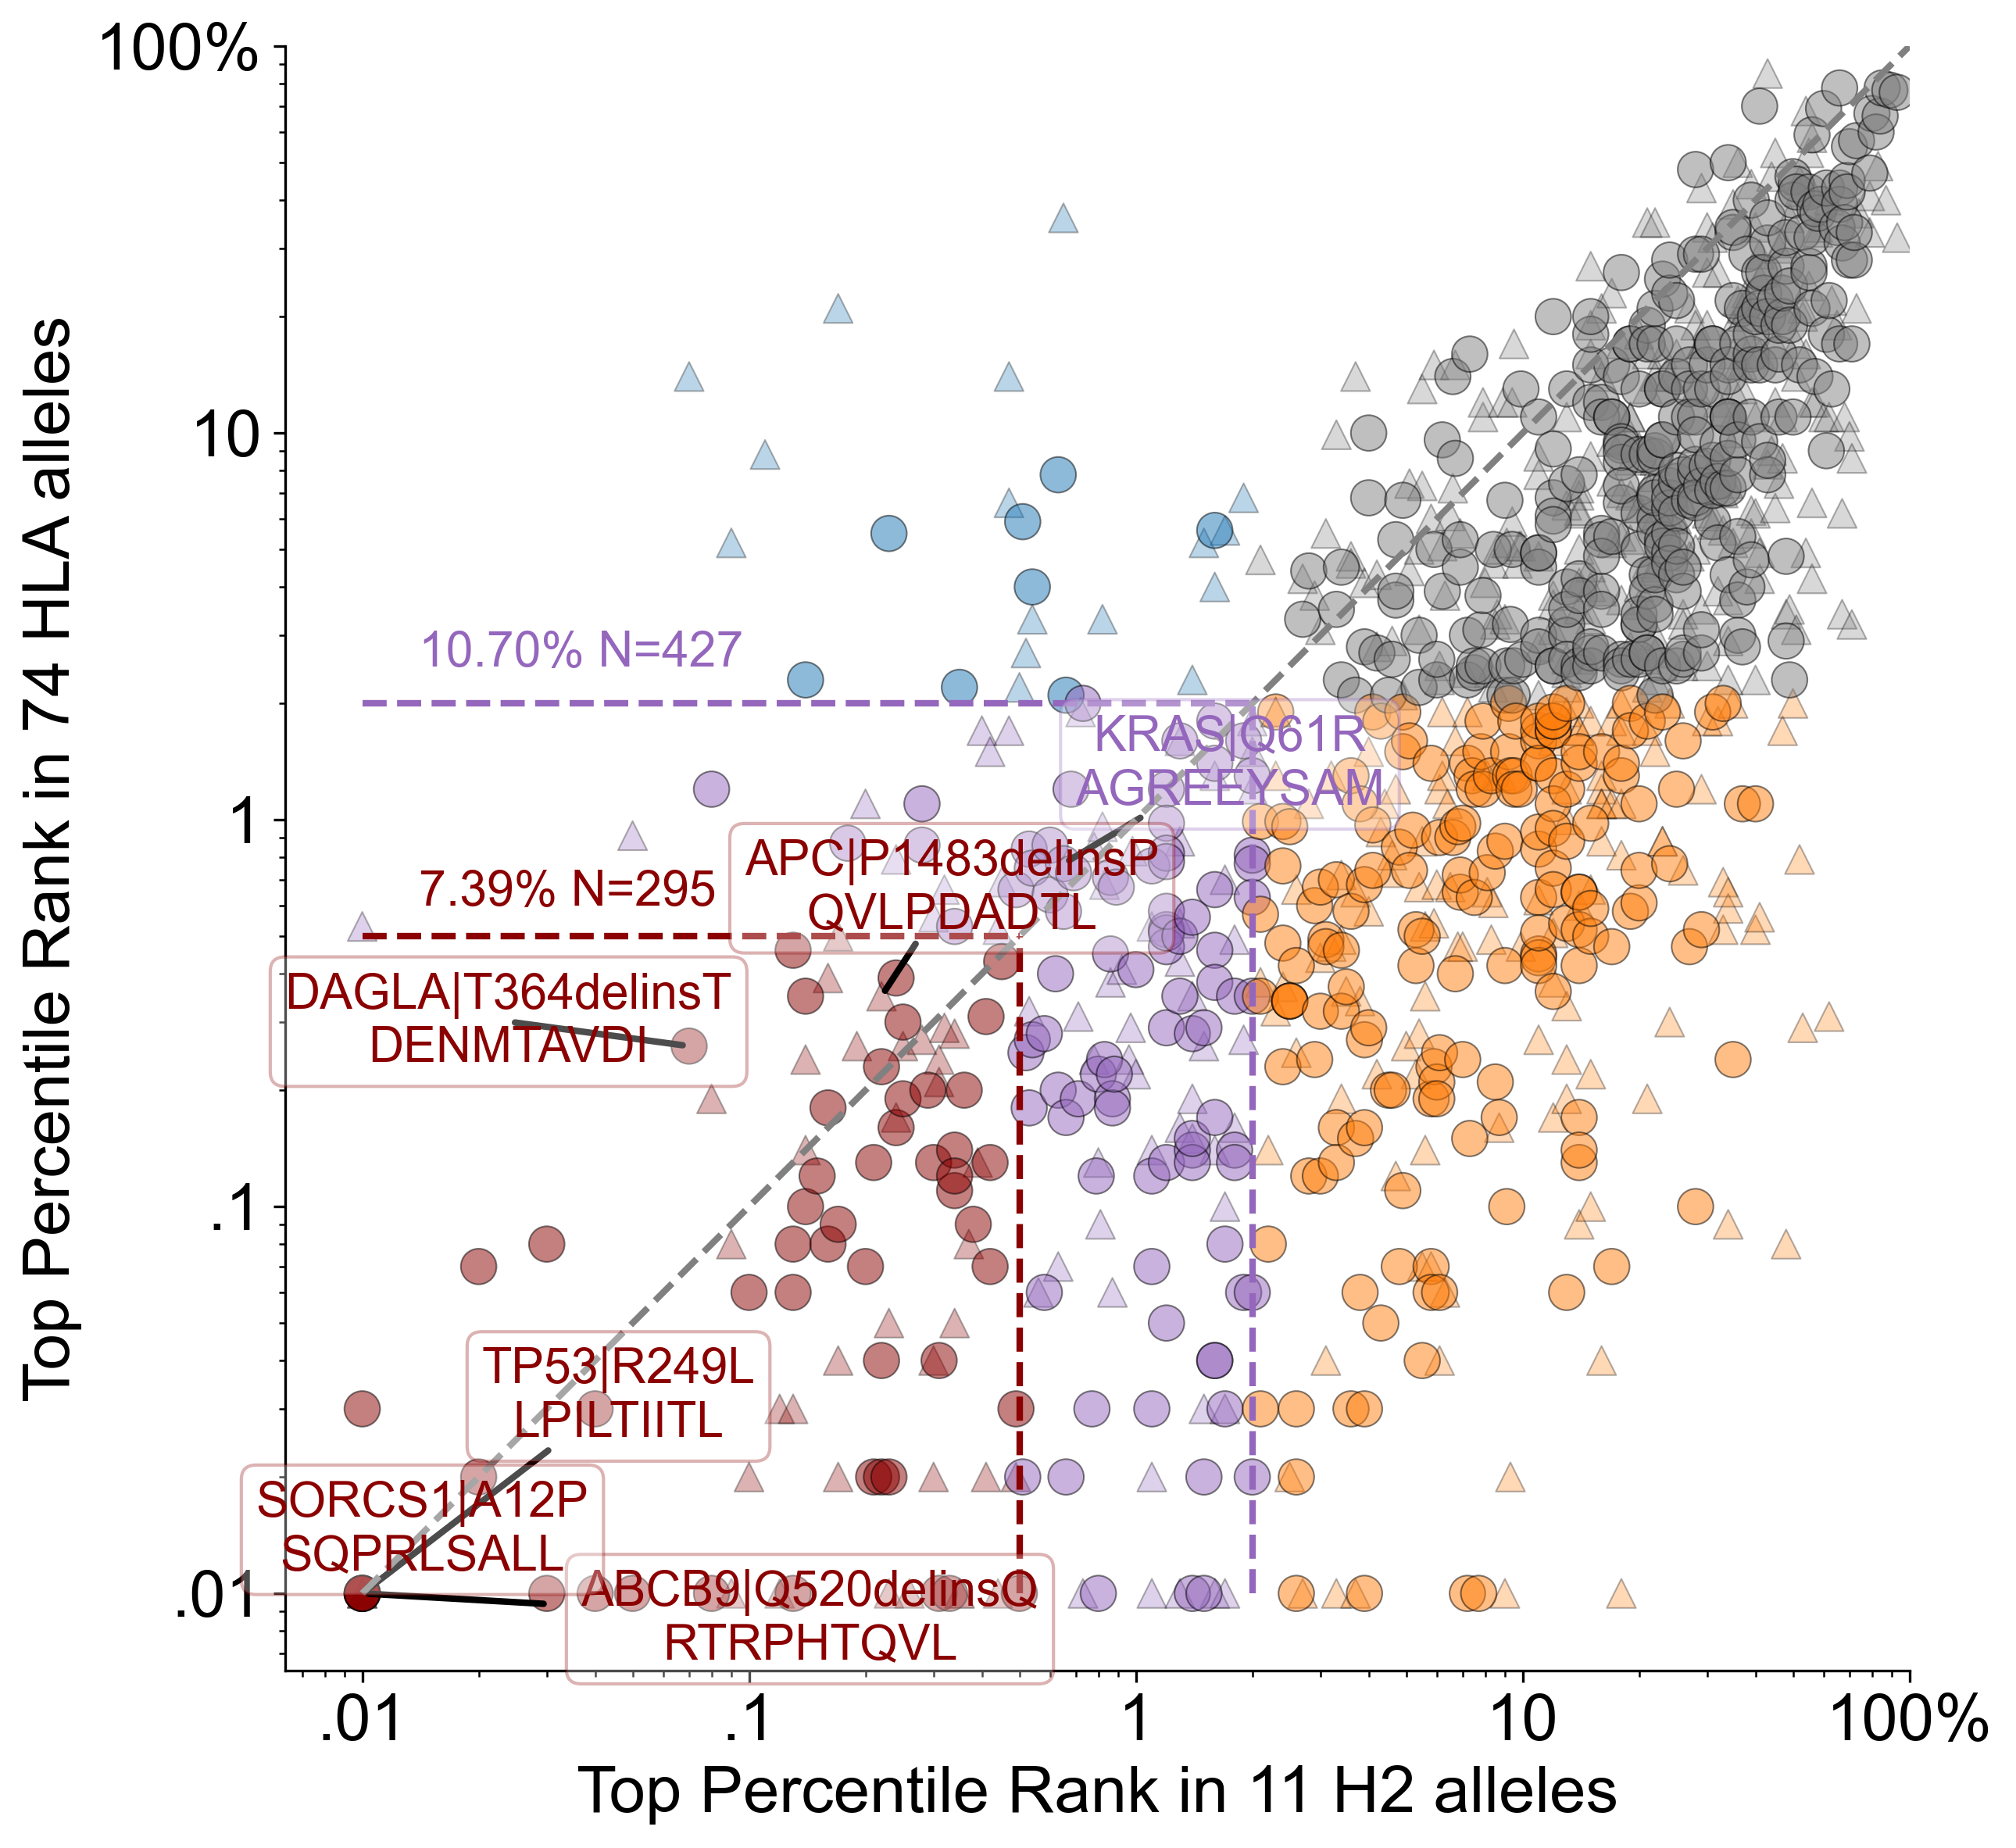

In [ ]:
l_plot = l_final
bbb1 = l_plot[[abs(x-y)<=0.05 for x,y in zip(l_plot['percentile_rank_m'],l_plot['percentile_rank_h'])]].iloc[:3,:]
bbb2 = l_plot[(l_plot['percentile_rank_h'] <= .01) & (l_plot['percentile_rank_m'] >= 85)].iloc[:3,:]
bbb3 = l_plot[l_plot['gene_name_h'].isin(['DAGLA','KRAS'])].iloc[:3,:]
bbb4 = l_plot[l_plot['gene_name_h'].isin(['TP53','EGFR','APC'])].iloc[:3,:]
bb2 = pd.concat([bbb1,bbb2,bbb3,bbb4]).drop_duplicates(subset=['gene_name_h','HGVSp_h'])

x = list(bb2['percentile_rank_m'])
y = list(bb2['percentile_rank_h'])
t = [f'{x}|{y}\n{p}' for x,y,p in zip(bb2['gene_name_h'], bb2['HGVSp_h'], bb2['human_9mers'])]
c = list(bb2['color'])


fig, ax = plt.subplots(figsize=(9, 9), dpi=300)

plot_1 = l_plot[[x==y for x,y in zip(l_plot['human_9mers'],l_plot['mouse_9mers'])]]
plot_2 = l_plot[[x!=y for x,y in zip(l_plot['human_9mers'],l_plot['mouse_9mers'])]]

ax.scatter(data=plot_2.sort_values('percentile_rank_m').drop_duplicates(subset='mouse_9mers'), x='percentile_rank_m', y='percentile_rank_h', c = 'color',alpha=.3, s=80, edgecolor='black', linewidths=.5, marker='^')
ax.scatter(data=plot_1.sort_values('percentile_rank_m').drop_duplicates(subset='mouse_9mers'), x='percentile_rank_m', y='percentile_rank_h', c = 'color',alpha=.5, s=120, edgecolor='black', linewidths=.5)

plt.xscale('log')
plt.yscale('log')
ax.plot([.01, 100], [.01, 100], linewidth=2, linestyle='--', color='grey')
ax.plot([.01, .5], [.5, .5], linewidth=2, linestyle='--', color='darkred')
ax.plot( [.5, .5], [.01, .5],linewidth=2, linestyle='--', color='darkred')
ax.plot([.01, 2], [2, 2], linewidth=2, linestyle='--', color='tab:purple')
ax.plot([2, 2], [.01, 2],linewidth=2, linestyle='--', color='tab:purple')

ax.set_aspect('equal')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel(f"Top Percentile Rank in 74 HLA alleles", fontsize=20)
ax.set_xlabel("Top Percentile Rank in 11 H2 alleles", fontsize=20)

ticks = [0.01, 0.1, 1, 10, 100]
labels = ['.01', '.1', '1', '10', '100%']

ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.yaxis.set_major_locator(FixedLocator(ticks))

ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: labels[pos]))
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: labels[pos]))

ax.tick_params(axis='both', labelsize=20)

# percentage label
l_1 = len(l_plot)
l_2 = len(l_plot[(l_plot['class']=='both') | (l_plot['class']=='strong')])
l_3 = len(l_plot[(l_plot['class']=='both')])
per_1=l_2/l_1*100
per_2=l_3/l_1*100

tt = [f'{per_1:.2f}% N={l_2}', f'{per_2:.2f}% N={l_3}']
xx = [.014,.014]
yy = [2.5,.6]
cc = ['tab:purple', 'darkred']

# ax.set_title(f"{per_1:.2f}% predicted to be presented by both human and mouse, MHC class I", fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

texts = [ax.text(x[i], y[i], t[i], fontsize=15, color=c[i],
ha='center', va='bottom',
                bbox=dict(facecolor='white', edgecolor=c[i], boxstyle='round,pad=0.3',alpha=.3))
         for i in range(len(x))]

adjust_text(texts,only_move={'texts':'xy'}, ax=ax, 

            arrowprops=dict(arrowstyle="-", linewidth=2, alpha=1, color='black'))

texts_per = [ax.text(xx[i], yy[i], tt[i], fontsize=15, color=cc[i])
         for i in range(len(xx))]

plt.savefig('figures/2h_main.pdf',bbox_inches='tight')
plt.show()

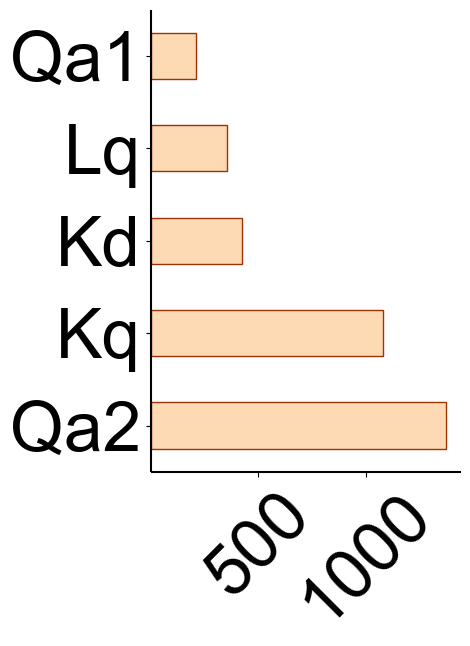

In [113]:
fig, ax = plt.subplots(figsize=(4,6))
allele_counts = l_final['H2_allele'].value_counts()[:5]
allele_counts = allele_counts
allele_counts.plot(kind='barh', color = plt.cm.Oranges(0.2) , edgecolor = plt.cm.Oranges(0.9))
plt.title('H2 Allele Frequency')  # 图表标题
plt.xlabel('Allele')  # x轴标签
plt.ylabel('Frequency')  # y轉标签
plt.xticks(rotation=45)  # x轴标签旋转45度
ax.set_axisbelow(True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_lw(1.5)
ax.spines["bottom"].set_capstyle("butt")
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks([500,1000])
ax.xaxis.set_ticklabels([500,1000], size=50, fontweight=100)
plt.yticks(fontsize = 50)
plt.title('')
plt.savefig('figures/2h_xcount.pdf',bbox_inches='tight')
plt.show()

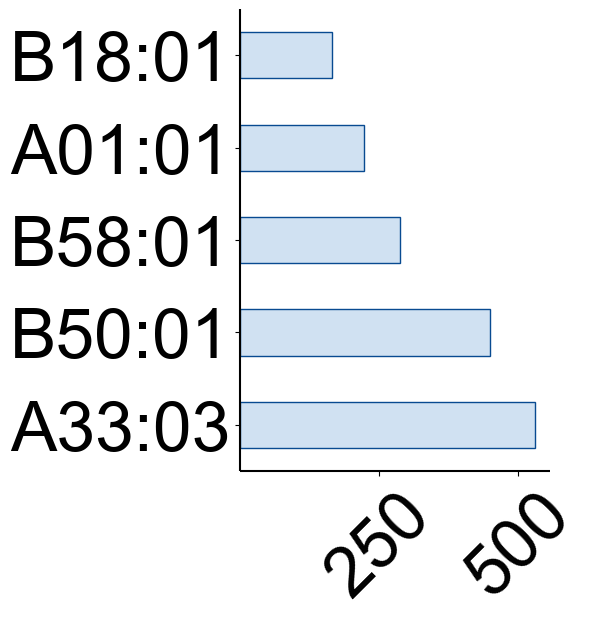

In [114]:
fig, ax = plt.subplots(figsize=(4,6))
allele_counts = l_final['HLA_alleles'].value_counts()[:5]
allele_counts = allele_counts
allele_counts.plot(kind='barh', color = plt.cm.Blues(0.2) , edgecolor = plt.cm.Blues(0.9))
plt.title('H2 Allele Frequency')  # 图表标题
plt.xlabel('Allele')  # x轴标签
plt.ylabel('Frequency')  # y轉标签
plt.xticks(rotation=45)  # x轴标签旋转45度
ax.set_axisbelow(True)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_lw(1.5)
ax.spines["bottom"].set_capstyle("butt")
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_ticks([250,500])
ax.xaxis.set_ticklabels([250,500], size=50, fontweight=100)
plt.yticks(fontsize = 50)
plt.title('')
plt.savefig('figures/2h_ycount.pdf',bbox_inches='tight')
plt.show()

In [115]:
len(plot_1)

607

In [116]:
len(plot_2)

3384

# Figure 2i

Relationship between AlphaMissense pathogenicity scores for human SMARCA4 and SMARCA2 mutation pairs.  

In [117]:
df_h2m = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/paralog/smarca.csv')

In [118]:
df_h2m

,gene_name_h_1,HGVSp_h_1,class,status,gene_name_h_2,HGVSp_h_2,flank_size,am_pathogenicity_1,am_class_1,am_pathogenicity_2,am_class_2,color_class,color_score,loc_h_1,loc_h_2,color_h2m_1,color_h2m_2
0,SMARCA4,T910M,1,True,SMARCA2,T880M,44,0.9817,pathogenic,0.9940,pathogenic,tab:green,#8b0000,910,880,darkred,darkred
1,SMARCA4,R1243W,0,True,SMARCA2,R1213W,82,0.9966,pathogenic,0.9959,pathogenic,tab:orange,#8b0000,1243,1213,darkred,darkred
2,SMARCA4,R1192H,0,True,SMARCA2,R1162H,82,0.9965,pathogenic,0.9968,pathogenic,tab:orange,#8b0000,1192,1162,darkred,darkred
3,SMARCA4,R1192C,0,True,SMARCA2,R1162C,82,0.9984,pathogenic,0.9969,pathogenic,tab:orange,#8b0000,1192,1162,darkred,darkred
4,SMARCA4,E882K,0,True,SMARCA2,E852K,61,0.9993,pathogenic,0.9998,pathogenic,tab:orange,#8b0000,882,852,darkred,darkred
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,SMARCA4,R1445C,1,True,SMARCA2,R1370C,13,0.9759,pathogenic,0.9837,pathogenic,tab:green,#8b0000,1445,1370,darkred,darkred
657,SMARCA4,S813L,0,True,SMARCA2,S783L,11,0.9973,pathogenic,0.9950,pathogenic,tab:orange,#8b0000,813,783,darkred,darkred
658,SMARCA4,F1121L,0,True,SMARCA2,F1091L,0,0.9871,pathogenic,0.9088,pathogenic,tab:orange,#8b0000,1121,1091,darkred,darkred
659,SMARCA4,D1183Y,0,True,SMARCA2,D1153Y,81,0.9985,pathogenic,0.9975,pathogenic,tab:orange,#8b0000,1183,1153,darkred,darkred


In [119]:
p_corr, p_value = scipy.stats.pearsonr(df_h2m['am_pathogenicity_1'], df_h2m['am_pathogenicity_2'])

print("Pearson Correlation Coefficient: {:.4f}".format(p_corr))
print(p_value)

Pearson Correlation Coefficient: 0.9281
6.774372165207511e-285


In [120]:
corr, p_value = scipy.stats.spearmanr(df_h2m['am_pathogenicity_1'], df_h2m['am_pathogenicity_2'])

print("Spearman Correlation Coefficient: {:.4f}".format(corr))
print(p_value)

Spearman Correlation Coefficient: 0.9563
0.0


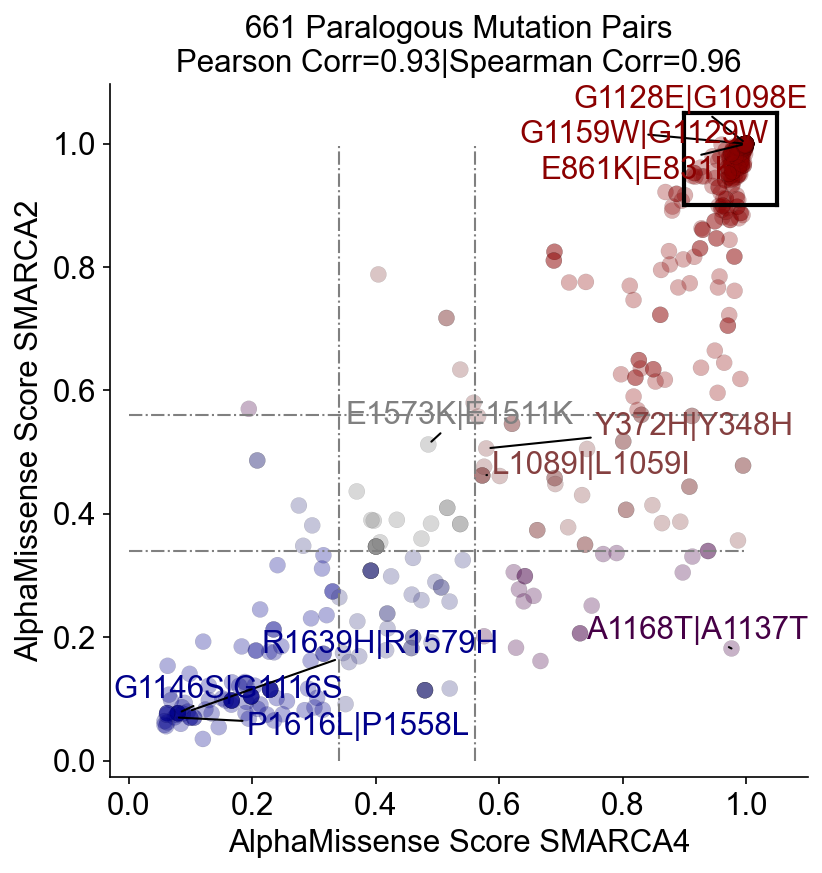

In [122]:
gene_1 = 'SMARCA4'
gene_2 = 'SMARCA2'

bbb1 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .9997) & (df_h2m['am_pathogenicity_2'] >= .9997) &(df_h2m['status'] == True)].iloc[:3,:]
bbb2 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .4) & (df_h2m['am_pathogenicity_1'] <= .6) & (df_h2m['am_pathogenicity_2'] <= .6) & (df_h2m['am_pathogenicity_2'] >= .4)].iloc[:3,:]
bbb3 = df_h2m[(df_h2m['am_pathogenicity_1'] <= .097) & (df_h2m['am_pathogenicity_2'] <= .097) &(df_h2m['status'] == True)].iloc[:3,:]
bbb4 = df_h2m[(df_h2m['am_pathogenicity_1'] <= .3) & (df_h2m['am_pathogenicity_2'] >= .8) &(df_h2m['status'] == True)].iloc[:3,:]
bbb5 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .8) & (df_h2m['am_pathogenicity_2'] <= .3) &(df_h2m['status'] == True)].iloc[:3,:]

bb2 = pd.concat((bbb1, bbb2,bbb3, bbb4, bbb5))

t = [f'{x}|{y}' for x,y in zip(bb2['HGVSp_h_1'], bb2['HGVSp_h_2'])]
x = list(bb2['am_pathogenicity_1'])
y = list(bb2['am_pathogenicity_2'])
c = list(bb2['color_class'])

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.axis('equal')
ax.plot([0, 1], [0.56, 0.56], linewidth=1, linestyle='-.', color='grey')
ax.plot([0, 1], [0.34, 0.34], linewidth=1, linestyle='-.', color='grey')

ax.plot( [0.56, 0.56], [0, 1],linewidth=1, linestyle='-.', color='grey')
ax.plot([0.34, 0.34], [0, 1], linewidth=1, linestyle='-.', color='grey')

ax.plot([.9, 1.05], [0.9, 0.9], linewidth=2, linestyle='-', color='black')
ax.plot([.9, 1.05], [1.05, 1.05], linewidth=2, linestyle='-', color='black')

ax.plot( [1.05, 1.05],[.9, 1.05],linewidth=2, linestyle='-', color='black')
ax.plot([0.9, 0.9],[.9, 1.05], linewidth=2, linestyle='-', color='black')


c = list(bb2['color_score'])
ax.scatter(data=df_h2m, x='am_pathogenicity_1', y='am_pathogenicity_2', c = 'color_score', alpha=.3, s=60, edgecolor='black', linewidths=.1)

ax.set_xlim(-.03, 1.1)
ax.set_ylim(-.03, 1.1)
ax.set_ylabel(f"AlphaMissense Score {gene_2}", fontsize=15)
ax.set_xlabel(f"AlphaMissense Score {gene_1}", fontsize=15)
ax.set_title(f"{len(df_h2m)} Paralogous Mutation Pairs\nPearson Corr={p_corr:.2f}|Spearman Corr={corr:.2f}", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
texts = [ax.text(x[i], y[i], t[i], fontsize=15, color=c[i],
                 # path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]
                  ) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
plt.savefig(f'figures/2i.pdf', bbox_inches='tight')
plt.show()

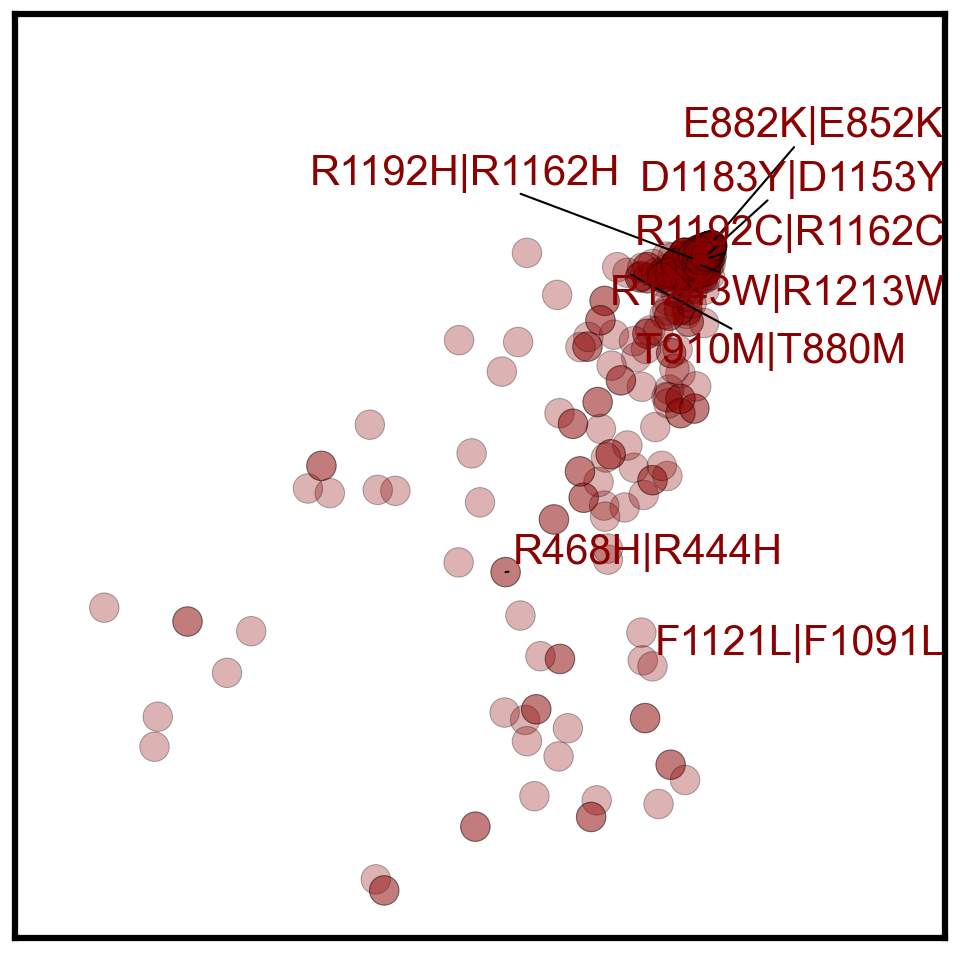

In [127]:
gene_1 = 'SMARCA4'
gene_2 = 'SMARCA2'

bbb1 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .8) & (df_h2m['am_pathogenicity_2'] >= .8) &(df_h2m['status'] == True)].iloc[:5,:]
bbb2 = df_h2m.iloc[[-2,-3,-18],:]
bb2 = pd.concat([bbb1, bbb2]).drop_duplicates()
t = [f'{x}|{y}' for x,y in zip(bb2['HGVSp_h_1'], bb2['HGVSp_h_2'])]
x = list(bb2['am_pathogenicity_1'])
y = list(bb2['am_pathogenicity_2'])
c = list(bb2['color_class'])

fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
ax.plot([0, 1], [0.56, 0.56], linewidth=1, linestyle='-.', color='grey')
ax.plot([0, 1], [0.34, 0.34], linewidth=1, linestyle='-.', color='grey')

ax.plot( [0.56, 0.56], [0, 1],linewidth=1, linestyle='-.', color='grey')
ax.plot([0.34, 0.34], [0, 1], linewidth=1, linestyle='-.', color='grey')

c = list(bb2['color_score'])
ax.scatter(data=df_h2m, x='am_pathogenicity_1', y='am_pathogenicity_2', c = 'color_score', alpha=.3, s=200, edgecolor='black', linewidths=.5)

ax.set_xlim(.85, 1.05)
ax.set_ylim(.85, 1.05)
ax.set_ylabel(f"", fontsize=10)
ax.set_xlabel(f"", fontsize=10)
ax.set_title(f"", fontsize=10)
ax.spines['top'].set_linewidth(3)  
ax.spines['bottom'].set_linewidth(3) 
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
boundaries_ = []
ax.xaxis.set_ticks(boundaries_)
ax.xaxis.set_ticklabels(boundaries_, size=30, fontweight=100)
ax.yaxis.set_ticks(boundaries_)
ax.yaxis.set_ticklabels(boundaries_, size=30, fontweight=100)

texts = [ax.text(x[i], y[i], t[i], fontsize=20, color=c[i], 
                 # path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]
                 ) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
plt.savefig(f'figures/2i_zoom.pdf', bbox_inches='tight')
plt.show()

# Figure 2k

Relationship between AlphaMissense pathogenicity scores for human paralogous mutation pairs that can be engineered in parallel with the same base editor and one single guide RNA. 

In [129]:
df_plot = pd.read_csv('/Users/kexindong/Documents/GitHub/Output/paralog/h2h_be_hit_by_single.csv')

In [130]:
df_plot = df_plot.drop('Protospacer',axis=1).drop_duplicates().reset_index(drop=True)

In [131]:
import matplotlib.colors as mcolors
import numpy as np
# Define the initial color dictionary
color_dict = {
    'pathogenic': 'darkred',
    'benign': 'darkblue',
    'ambiguous': 'grey'
}

# Function to blend two colors
def blend_colors(color1, color2):
    # Convert color names to RGBA
    rgb1 = np.array(mcolors.to_rgb(color1))
    rgb2 = np.array(mcolors.to_rgb(color2))
    # Calculate the average of the RGB components
    blended_rgb = (rgb1 + rgb2) / 2
    # Convert the blended RGB back to hex color code
    return mcolors.to_hex(blended_rgb)

# Create a combined color dictionary
combined_color_dict = {}
for key1 in color_dict:
    for key2 in color_dict:
        # Blend each pair of colors
        combined_color_dict[(key1, key2)] = blend_colors(color_dict[key1], color_dict[key2])

In [132]:
df_h2m = df_plot
# df_h2m['color_class'] = [color_dict_h2m[x] for x in df_h2m['class']]
df_h2m['color_score'] = df_h2m.apply(lambda row: combined_color_dict[(row['am_class_1'], row['am_class_2'])], axis=1)

In [133]:
corr_p, p_value = scipy.stats.pearsonr(df_h2m['am_pathogenicity_1'], df_h2m['am_pathogenicity_2'])

print("Pearson Correlation Coefficient: {:.4f}".format(corr_p))
print(p_value)
print("P-value: {:.4f}".format(p_value))

Pearson Correlation Coefficient: 0.8547
3.968997845201213e-51
P-value: 0.0000


In [134]:
corr, p_value = scipy.stats.spearmanr(df_h2m['am_pathogenicity_1'], df_h2m['am_pathogenicity_2'])

print("Spearman Correlation Coefficient: {:.4f}".format(corr))
print(p_value)
print("P-value: {:.4f}".format(p_value))

Spearman Correlation Coefficient: 0.8484
1.1278338653458245e-49
P-value: 0.0000


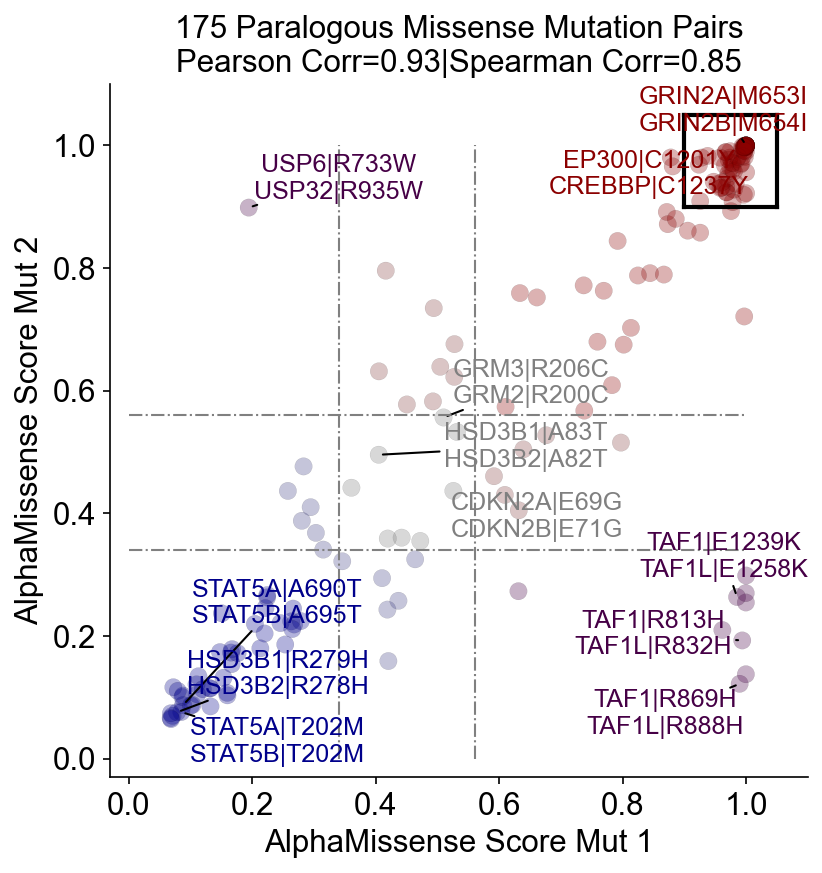

In [138]:
bbb1 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .9997) & (df_h2m['am_pathogenicity_2'] >= .9997)].iloc[:2,:]
bbb2 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .4) & (df_h2m['am_pathogenicity_1'] <= .6) & (df_h2m['am_pathogenicity_2'] <= .6) & (df_h2m['am_pathogenicity_2'] >= .4)].iloc[:3,:]
bbb3 = df_h2m[(df_h2m['am_pathogenicity_1'] <= .097) & (df_h2m['am_pathogenicity_2'] <= .097) ].iloc[:3,:]
bbb4 = df_h2m[(df_h2m['am_pathogenicity_1'] <= .3) & (df_h2m['am_pathogenicity_2'] >= .8)].iloc[:3,:]
bbb5 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .8) & (df_h2m['am_pathogenicity_2'] <= .3)].iloc[:3,:]

bb2 = pd.concat((bbb1, bbb2,bbb3, bbb4, bbb5))

t = [f'{p}|{x}\n{q}|{y}' for p,q,x,y in zip(bb2['Hugo_Symbol_1'], bb2['Hugo_Symbol_2'],bb2['HGVSp_h_1'], bb2['HGVSp_h_2'])]
x = list(bb2['am_pathogenicity_1'])
y = list(bb2['am_pathogenicity_2'])



fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.plot([0, 1], [0.56, 0.56], linewidth=1, linestyle='-.', color='grey')
ax.plot([0, 1], [0.34, 0.34], linewidth=1, linestyle='-.', color='grey')

ax.plot( [0.56, 0.56], [0, 1],linewidth=1, linestyle='-.', color='grey')
ax.plot([0.34, 0.34], [0, 1], linewidth=1, linestyle='-.', color='grey')


ax.plot([.9, 1.05], [0.9, 0.9], linewidth=2, linestyle='-', color='black')
ax.plot([.9, 1.05], [1.05, 1.05], linewidth=2, linestyle='-', color='black')

ax.plot( [1.05, 1.05],[.9, 1.05],linewidth=2, linestyle='-', color='black')
ax.plot([0.9, 0.9],[.9, 1.05], linewidth=2, linestyle='-', color='black')

c = list(bb2['color_score'])
ax.scatter(data=df_h2m, x='am_pathogenicity_1', y='am_pathogenicity_2', c = 'color_score', alpha=.3, s=70, edgecolor='black', linewidths=.1)

ax.set_xlim(-.03, 1.1)
ax.set_ylim(-.03, 1.1)
ax.set_ylabel(f"AlphaMissense Score Mut 2", fontsize=15)
ax.set_xlabel(f"AlphaMissense Score Mut 1", fontsize=15)
ax.set_title(f"{len(df_h2m)} Paralogous Missense Mutation Pairs\nPearson Corr={p_corr:.2f}|Spearman Corr={corr:.2f}", fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
texts = [ax.text(x[i], y[i], t[i], fontsize=12, color=c[i], 
                # path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]
                 ) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
plt.savefig(f'figures/2k.pdf', bbox_inches='tight')
plt.show()

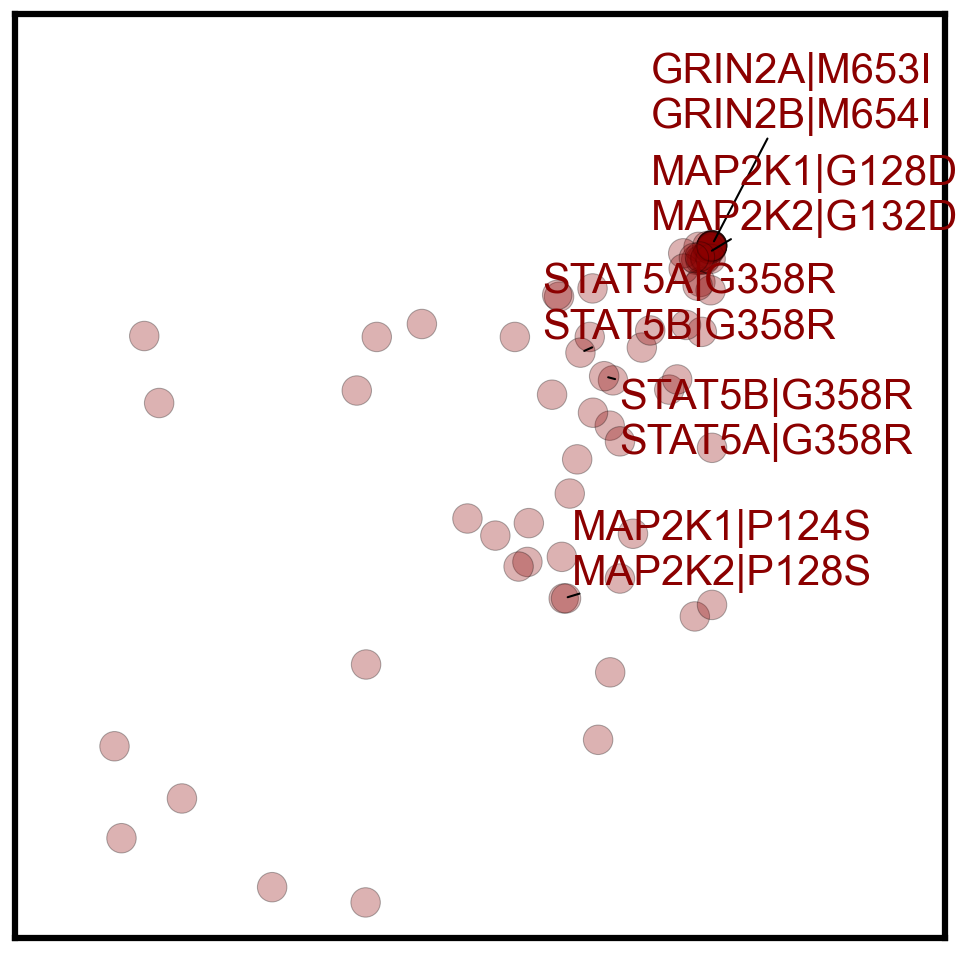

In [139]:
bbb1 = df_h2m[(df_h2m['am_pathogenicity_1'] >= .9) & (df_h2m['am_pathogenicity_2'] >= .9)].iloc[[2,6,8,35,47],:]

bb2 = bbb1

t = [f'{p}|{x}\n{q}|{y}' for p,q,x,y in zip(bb2['Hugo_Symbol_1'], bb2['Hugo_Symbol_2'],bb2['HGVSp_h_1'], bb2['HGVSp_h_2'])]
x = list(bb2['am_pathogenicity_1'])
y = list(bb2['am_pathogenicity_2'])

fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
ax.plot([0, 1], [0.56, 0.56], linewidth=1, linestyle='-.', color='grey')
ax.plot([0, 1], [0.34, 0.34], linewidth=1, linestyle='-.', color='grey')

ax.plot( [0.56, 0.56], [0, 1],linewidth=1, linestyle='-.', color='grey')
ax.plot([0.34, 0.34], [0, 1], linewidth=1, linestyle='-.', color='grey')

c = list(bb2['color_score'])
ax.scatter(data=df_h2m, x='am_pathogenicity_1', y='am_pathogenicity_2', c = 'color_score', alpha=.3, s=200, edgecolor='black', linewidths=.5)

ax.set_xlim(.85, 1.05)
ax.set_ylim(.85, 1.05)
ax.set_ylabel(f"", fontsize=10)
ax.set_xlabel(f"", fontsize=10)
ax.set_title(f"", fontsize=10)
ax.spines['top'].set_linewidth(3)  
ax.spines['bottom'].set_linewidth(3) 
ax.spines['left'].set_linewidth(3) 
ax.spines['right'].set_linewidth(3) 
boundaries_ = []
ax.xaxis.set_ticks(boundaries_)
ax.xaxis.set_ticklabels(boundaries_, size=30, fontweight=100)
ax.yaxis.set_ticks(boundaries_)
ax.yaxis.set_ticklabels(boundaries_, size=30, fontweight=100)
texts = [ax.text(x[i], y[i], t[i], fontsize=20, color=c[i], 
                # path_effects=[PathEffects.withStroke(linewidth=2, foreground="w")]
                 ) for i in range(len(x))]
adjust_text(texts,only_move={'texts':'xy'}, ax=ax, arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))
plt.savefig(f'figures/2i_zoom.pdf', bbox_inches='tight')
plt.show()